## PRINCIPAL COMPONENT ANALYSIS

Principal component analysis (PCA) is a method that is used to transform a set of variables into a smaller set of variables that explain most of the variability in the original dataset. PCA has no response variable, so it is an "unsupervised" learning method.The principal components are orthogonal to one another, they are statistically linearly independent of one another… which is why our columns of reduced data are linearly independent of one another!

Why would we want to use such a method? It can be useful for data compression and visualization, and the results can also be used in other downstream tasks, such as regression, classification, and clustering. Using the results from PCA instead of the original features often leads to less noisy results, as the first few principal components tend to contain the signal in data (as opposed to the noise). One downside is that after applying PCA, the regression and classification coefficients often become uninterpretable.

The goal of PCA is to project a dataset consisting of observations  $x_1,\dots,x_n$∈$ℝ^𝐷$  onto a lower dimensional subspace of dimension  p  such that we maximize the variance of the projected data. An equivalent way of viewing PCA is that we are projecting the data onto a subspace that is "closest" to the observations. If we try to reconstruct the original data from the data projected using PCA, we will get the "best" possible reconstruction.The first principal component is the direction that captures the most variance. The second principal component is the direction that is orthogonal to the first direction and captures as much variance as possible, etc. Each principal component is orthogonal to the previous components. 

Prior to performing PCA we should standardize the variables to have a mean of zero and a standard deviation of 1. 
Take the matrix of independent variables X and, for each column, subtract the mean of that column from each entry. (This ensures that each column has a mean of zero.). Decide whether or not to standardize. Given the columns of X, are features with higher variance more important than features with lower variance, or is the importance of features independent of the variance? (In this case, importance means how well that feature predicts Y.) If the importance of features is independent of the variance of the features, then divide each observation in a column by that column’s standard deviation.

First, the covariance matrix XᵀX is a matrix that contains estimates of how every variable in X relates to every other variable in X. Understanding how one variable is associated with another is quite powerful.

Second, eigenvalues and eigenvectors are important. Eigenvectors represent directions. Think of plotting your data on a multidimensional scatterplot. Then one can think of an individual eigenvector as a particular “direction” in your scatterplot of data. Eigenvalues represent magnitude, or importance. Bigger eigenvalues correlate with more important directions.

Lots of variability usually indicates signal, whereas little variability usually indicates noise. Thus, the more variability there is in a particular direction is, theoretically, indicative of something important we want to detect. 


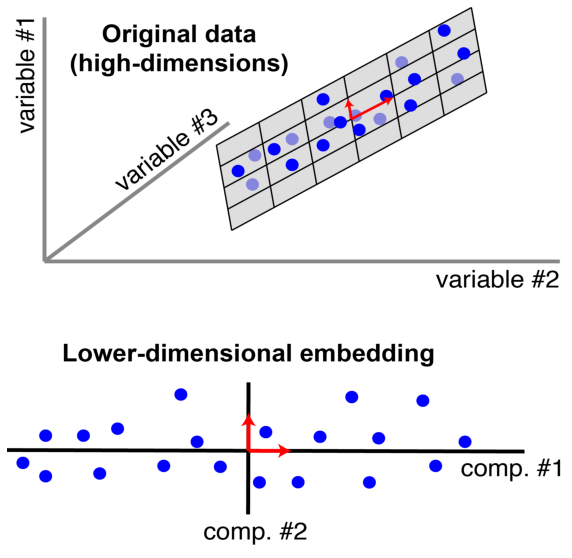

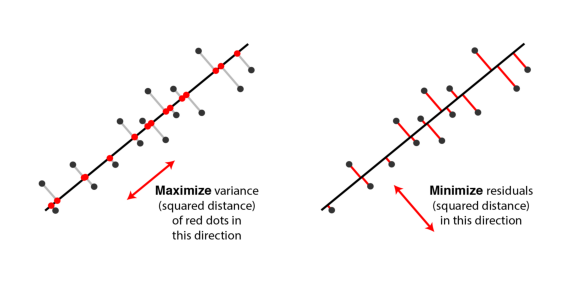

In [537]:
from io import BytesIO
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image, ImageOps  # PIL is the Python Imaging Library
import requests

image_url1 = 'http://alexhwilliams.info/itsneuronalblog/img/pca/pca_classic.png'
image_url2 = 'http://alexhwilliams.info/itsneuronalblog/img/pca/pca_two_views.png'
for i in range(0, 2):
    image_url = image_url1 if i==0 else image_url2
    response = requests.get(image_url)
    pca_figure = Image.open(BytesIO(response.content))
    if i == 0:
        fig, ax = plt.subplots(figsize=(10, 10))
    else:
        fig, ax = plt.subplots(figsize=(10, 5))
    fig = ax.imshow(np.asarray(pca_figure), aspect='auto')
    plt.axis('off')
    plt.show()

In the first picture, we have three-dimensional data ($D=3$) and each blue point is an observation. When using PCA to reduce this data to two dimensions, we find the plane that is closest to the data. Equivalently, we find the directions that capture the largest amount of the variance in the data and such that the directions are orthogonal. The red arrows represent the directions with the largest variance.

In the picure at the bottom there are $n=16$ observations $x_1,\dots, x_{16}$ (the gray points), each with $D=2$ dimensions. The image shows the results of running PCA on these observations. The direction with the maximum variation in the data is denoted by the black line. Hence, if we project the data down to one dimension, we will maximize the variance of the projected data if we project along this axis. Equivalently, the distance between the points and a subspace (a line) is at a minimum if we choose the line to be the black line in the picture. The red points are the values of the observations after they were projected onto the first principal component $v_1$. 

During the lectures you learned how you can compute $v_1,\dots, v_p$. A note on terminology before continuing: Some references call $v_1$ a principal component, whereas others call $Xv_1$ a principal component. 

### Assumptions and Advantages of PCA

- Linearity : PCA assumes that the principle components are a linear combination of the original features. If this is not true, PCA will not give you sensible results.
- Large variance implies more structure : PCA uses variance as the measure of how important a particular dimension is. So, high variance axes are treated as principle components, while low variance axes are treated as noise.
- Orthogonality : PCA assumes that the principle components are orthogonal.

PCA can be useful in exploring large data sets to see the structure of the relationships among variables when a correlation matrix would be overwhelming. Also, unlike correlation, it allows for relationships among sets of variables, rather than just pairs. Sometimes PCA doesn’t work. If the variables are all very uncorrelated, PCA may not be very useful.

Advantages:
    
- Lack of redundancy of data given the orthogonal components 
- Reduced complexity in images’ grouping with the use of PCA
- Smaller database representation since only the trainee images are stored in the form of their projections on a reduced basis
- Reduction of noise since the maximum variation basis is chosen and so the small variations in the back-ground are ignored automatically. It filters out the noise, and leaves us with stronger signal.

### Import packages

In [538]:
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext
import pandas as pd
import re
from operator import add
from itertools import product
import sys
import numpy as np
import matplotlib.pyplot as plt 

### Read the data

We read the face dataset from sklearn.datasets

Here, we will not divide by the standard deviation because the features are already normalized to be between 0 and 255.

In [539]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_lfw_people

faces = fetch_lfw_people(min_faces_per_person=30) 
print('People in the dataset:', faces.target_names)  # Images of 34 different people
print('Dimensions of data:', faces.images.shape)  # 1666 images, each of which is 62x47 pixels
print('Dimension of unraveled data:', faces.data.shape)  

People in the dataset: ['Alejandro Toledo' 'Andre Agassi' 'Ariel Sharon' 'Colin Powell'
 'Donald Rumsfeld' 'George W Bush' 'Gerhard Schroeder'
 'Gloria Macapagal Arroyo' 'Hans Blix' 'Junichiro Koizumi' 'Kofi Annan'
 'Laura Bush' 'Lleyton Hewitt' 'Megawati Sukarnoputri' 'Serena Williams'
 'Tony Blair' 'Vicente Fox']
Dimensions of data: (1666, 62, 47)
Dimension of unraveled data: (1666, 2914)


### Covariance matrix

In [540]:
def compute_cov_full(X):
    n,d = X.shape
    return (1/n)*(X.T.dot(X))

In [541]:
X=faces.data
X_demean = X - np.mean(X,axis=0) #if demeaning the data
cov_faces = compute_cov_full(X_demean)

### Plot original images

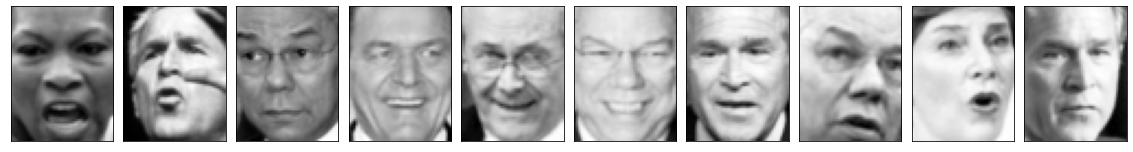

In [542]:
# Look at some of the faces
fig, ax = plt.subplots(1, 10, figsize=(20, 5),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
start = 700
for i in range(start, start+10):
    ax[i-start].imshow(X[i, :].reshape(62, 47), cmap='Greys_r')
plt.show()

## 1. PCA using Eigen decomposition

In [543]:
eigen_vals, eigen_vecs = np.linalg.eigh(cov_faces)
idx = eigen_vals.argsort()[::-1]
eigen_vals_sorted = eigen_vals[idx]
eigen_vecs_sorted = eigen_vecs[:,idx]
top_50_eig_vecs = eigen_vecs_sorted[:,:50]
top_50_eig_vals = eigen_vals_sorted[:50]

In [544]:
print("top_50_eig_vals",top_50_eig_vals.shape)
print("top_50_eig_vecs",top_50_eig_vecs.shape) #d*p

top_50_eig_vals (50,)
top_50_eig_vecs (2914, 50)


#### Top 2 eigen values and eigen vectors

In [545]:
print('****First Eigen value***')
print(eigen_vals_sorted[0])
print('*******First principal component*****')
print(eigen_vecs_sorted[:,0])
print()
print('****Second Eigen value***')
print(eigen_vals_sorted[1])
print('*******Second principal component:*****')
print(eigen_vecs_sorted[:,1])

****First Eigen value***
1022065.4
*******First principal component*****
[-0.00275768 -0.003669   -0.00503992 ... -0.00826745 -0.00717774
 -0.00644891]

****Second Eigen value***
590401.0
*******Second principal component:*****
[ 0.01458718  0.01397873  0.01419204 ... -0.03599009 -0.03504829
 -0.03373259]


#### What are the eigenvalues λ1, λ2, λ10, λ30, and λ50? Also, what is the sum of all the eigenvalues λi where i=1 to d? 

In [546]:
lamdba_1 = top_50_eig_vals[0]
lamdba_2 = top_50_eig_vals[1]
lamdba_10 = top_50_eig_vals[9]
lamdba_30 = top_50_eig_vals[29]
lamdba_50 = top_50_eig_vals[49]
print(lamdba_1,lamdba_2,lamdba_10,lamdba_30,lamdba_50)

1022065.4 590401.0 75649.62 19467.262 10072.663


In [547]:
all_eigen_values_sum = np.trace(cov_faces)
print(all_eigen_values_sum)

4577989.0


#### Plot this fractional reconstruction error for each of the first 50 values of k (i.e. k from 1 to 50). So the X-axis is k and the Y -axis is the fractional reconstruction error. 

In [548]:
def reconst_err(k):
    top_k_eig_vals = eigen_vals_sorted[:k]
    return 1 - (np.sum(top_k_eig_vals)/np.sum(all_eigen_values_sum))

In [549]:
reconst_error = [reconst_err(k) for k in range(500)]

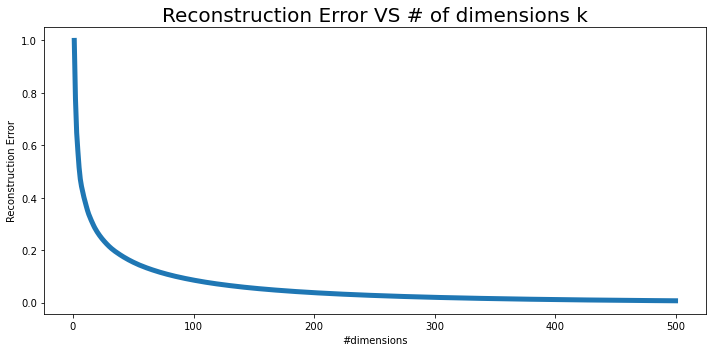

In [550]:
import matplotlib.pyplot as plt 
f, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.set_title('Reconstruction Error VS # of dimensions k', fontsize=20)
ax.set_xlabel('#dimensions', fontsize=10)
ax.set_ylabel('Reconstruction Error', fontsize=10)
dim = [x for x in range(1,501)]
ax.plot(dim,reconst_error,linewidth=5)
plt.tick_params(labelsize=10)
plt.tight_layout()

#### Explain what the first eigenvalue captures, and why you think λ1 is much larger than the other eigenvalues

In PCA, data is projected onto a lower dimensional sub-space such that the variance is maximum and reconstruction error is minimum. Top principal component is the vector on to which data is projected such that along the direction associated with it, variance is maximum. Top eigen value is a scalar value that tells us how the data is spread out on the top principal axis/vector. Highest value for lamda1 implies first pricipal component or the top eigen vector captures most of the variance as compared to other pricipal components which are orthognal to first pricipal component.

### Visualization of the Eigen-Directions

#### Original images

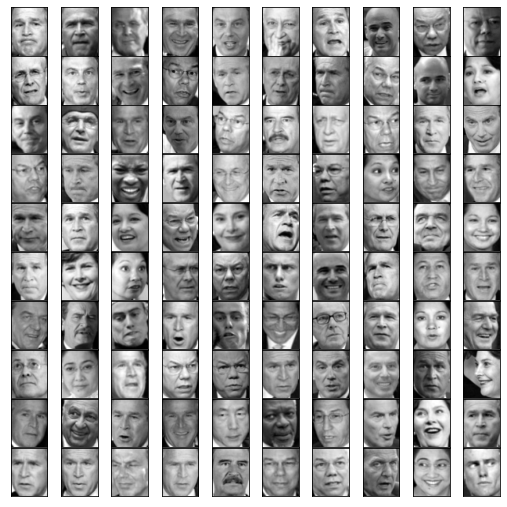

In [551]:
fig, axes = plt.subplots(10,10,figsize=(9,9),
 subplot_kw={'xticks':[], 'yticks':[]},
 gridspec_kw=dict(hspace=0.01, wspace=0.01))
for i, ax in enumerate(axes.flat):
    ax.imshow(X[i,:].reshape(62, 47),cmap="gray")

#### Reconstructed images using 200 PCs

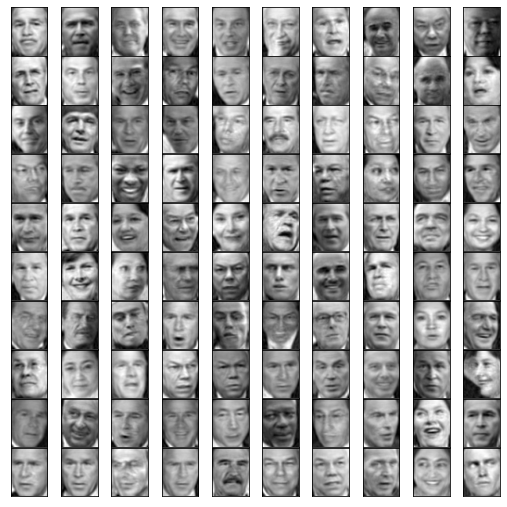

In [552]:
top_k_eig_vecs = eigen_vecs_sorted[:,:200]
X_reduced = (top_k_eig_vecs.T.dot(X_demean.T)).T 
X_reconstruct = top_k_eig_vecs.dot(X_reduced.T).T + np.mean(X,axis=0)
fig, axes = plt.subplots(10,10,figsize=(9,9), subplot_kw={'xticks':[], 'yticks':[]},
            gridspec_kw=dict(hspace=0.01, wspace=0.01))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_reconstruct[i].reshape(62,47),cmap="gray")

In [553]:
pca_scores_df = pd.DataFrame(data = X_reduced[:,:2], columns =['pca1',
                                                   'pca2'])
print(pca_scores_df.head())

          pca1         pca2
0  -781.003418  -237.931549
1  1236.011597   734.590698
2   170.568146 -1359.864746
3  1360.043457   287.000519
4  -985.719727  1236.502808


#### Display the first 10 eigenvectors as images.

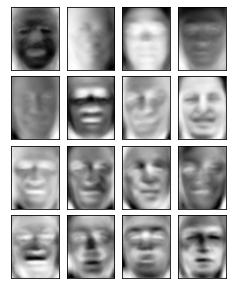

In [554]:
fig, axes = plt.subplots(4, 4, figsize=(5, 5), subplot_kw={'xticks':[], 'yticks':[]},
                        gridspec_kw={'hspace': 0.1, 'wspace': -0.5})
for i, ax in enumerate(fig.axes):
    # Replace np.zeros(62*47) with principal component i below 
    ax.imshow(np.reshape(eigen_vecs_sorted[:,i], (62, 47)), cmap='Greys_r')

#### What you think each eigenvector captures.

The first few top principal components capture most of the information or most of the variance. The first few principal components capture the differences in the lighting across the images. Others seem to capture the variation in the eyes, noses, and facial hair.

### Visualization and Reconstruction

#### We will now observe the reconstruction using PCA on a sample of images composed of the following images:

(a) image 1 (row 0).
(b) image 24 (row 23).
(c) image 65 (row 64).
(d) image 68 (row 67).
(e) image 257 (row 256).
For each of these images, plot the original image and plot the projection of the image
onto the top k eigenvectors of Σ for k = 1, 2, 5, 10, 50, 100, 200

In [555]:
def pca_plot_with_orig(image_dict):
    fig, axarr = plt.subplots(1,9,figsize=(10,10),
    subplot_kw={'xticks':[], 'yticks':[]},
    gridspec_kw=dict(hspace=0.1, wspace=0.1))
    
    for img,approx in image_dict.items():
        j=0
        print("Image#",img)
        all_faces_reshape[img-1,] = faces.data[img-1,].reshape(-1,62,47)
        #all_faces_reshape[img-1,] = all_faces_reshape[img-1,].T
        axarr[j].imshow(all_faces_reshape[img-1,],cmap='gray')
        axarr[j].set_title('Original', fontsize=10)
        axarr[j].axis('off')
        for i,app in enumerate(approx):
            k=approx[i][0]
            app=approx[i][1]
            approximation_reshape[img-1,] = app[img-1,].reshape(-1,62,47)
            #approximation_reshape[img-1,] = approximation_reshape[img-1,].T
            j += 1
            axarr[j].imshow(approximation_reshape[img-1,],cmap='gray')
            axarr[j].set_title(' pc# '+str(k), fontsize=10)
            axarr[j].axis('off')
    plt.show()

Image# 1


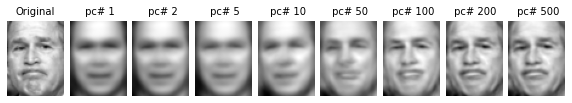

Image# 24


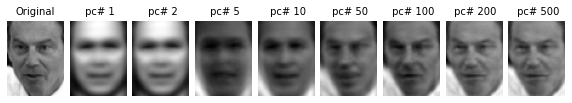

Image# 65


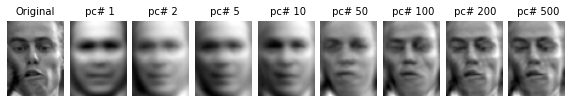

Image# 68


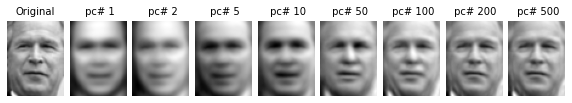

Image# 257


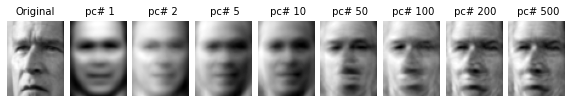

In [556]:
k_list = [1, 2, 5, 10, 50, 100, 200, 500]
image_list = [1,24,65,68,257]
all_faces_reshape = faces.data.reshape(-1,62,47)
i=-1
j=0

for imagenum in image_list : 
    image_dict={}
    image_dict[imagenum] = []
    
    for k in k_list:
        top_k_eig_vecs = eigen_vecs_sorted[:,:k] # d * p
        X_reduced = (top_k_eig_vecs.T.dot(X_demean.T)).T 
        X_reconstruct = top_k_eig_vecs.dot(X_reduced.T).T + np.mean(X,axis=0)
        approximation = X_reconstruct
        approximation_reshape = approximation.reshape(-1,62,47)
        image_dict[imagenum].append((k,approximation))       
    pca_plot_with_orig(image_dict)

## 2. PCA using scikit-learn
Let's try running PCA with scikit-learn. By default, scikit-learn will use the randomized PCA version since the dimensions of the data are so large. 

In [557]:
from sklearn.decomposition import PCA
pca = PCA(n_components=200)
pca_scores = pca.fit_transform(X_demean)

The PCA class has several important attributes and methods. The attributes that are relevant to us are:
- components_ : "Principal axes in feature space, representing the directions of maximum variance in the data. The components are sorted by explained\_variance\_."
- explained_variance\_ratio\_ : "Percentage of variance explained by each of the selected components."

In [558]:
print('****First Eigen value***')
print(pca.explained_variance_[0])
print('*******First principal component*****')
print(pca.components_[0])
print()
print('****Second Eigen value***')
print(pca.explained_variance_[1])
print('*******Second principal component:*****')
print(pca.components_[1])

****First Eigen value***
1022679.0
*******First principal component*****
[-0.00275765 -0.00366899 -0.00503991 ... -0.00826744 -0.00717772
 -0.0064489 ]

****Second Eigen value***
590754.2
*******Second principal component:*****
[ 0.0145872   0.0139787   0.01419206 ... -0.03599007 -0.03504826
 -0.03373256]


In [559]:
pca_scores_df = pd.DataFrame(data = pca_scores[:,:2], columns =['pca1',
                                                   'pca2'])
print(pca_scores_df.head())

          pca1         pca2
0  -780.995422  -237.931213
1  1236.010986   734.585388
2   170.568359 -1359.862793
3  1360.042969   287.000305
4  -985.719604  1236.501343


#### Visualize the principal components

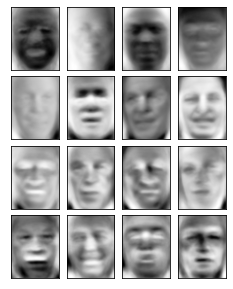

In [560]:
# But if we reshape the principal components, we can visualize them
fig, axes = plt.subplots(4, 4, figsize=(5, 5), subplot_kw={'xticks':[], 'yticks':[]},
                        gridspec_kw={'hspace': 0.1, 'wspace': -0.5})
for i, ax in enumerate(fig.axes):
    # Replace np.zeros(62*47) with principal component i below 
    ax.imshow(np.reshape(pca.components_[i], (62, 47)), cmap='Greys_r')

#### How many principal components?
One question we need to answer is "How many principal components should we use?" We want enough principal components to capture most of the variation in the data, but not too many. This tends to be a problem- and data-specific question. If we're performing PCA for use in a supervised learning task, then we can use cross-validation to choose the best number of components. Other ways that are ad-hoc include:
- Choosing the smallest number of components such that a certain percentage of the variance is retained (e.g., 95%)
- Looking at what's called a "scree plot", which is a plot of the percent of variance captured by each principal component. The "elbow" method looks at where there plot goes from having a steep slope to being relatively flat and takes the point just before that occurs to be the number of principal components to use.

Let's see how we could go about using the latter two methods:

#### How much variance is explained by the first 25 principal components? How many components are necessary to capture 95% of the variance in the data? 

Because each eigenvalue is roughly the importance of its corresponding eigenvector, the proportion of variance explained is the sum of the eigenvalues of the features you kept divided by the sum of the eigenvalues of all features. If there's a big drop in proportion of variability explained between a principal component relative to previous principal component

In [561]:
print('Variance explained by first 100: ', np.sum(pca.explained_variance_ratio_[0:100]))

Variance explained by first 100:  0.9148565


In [562]:
cumsum = np.cumsum(pca.explained_variance_ratio_)
print(np.where(cumsum > 0.95)[0][0]+1) # add 1 due to zero-based indexing

162


#### Plot the percent of variance explained by each component vs. the component number. Based on the elbow method heuristic, how many principal components would you choose?

Text(0, 0.5, 'Fraction of variance explained')

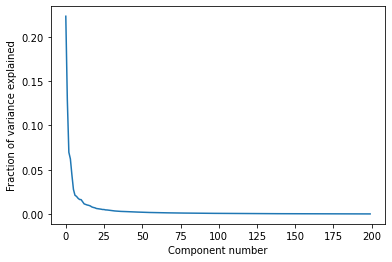

In [563]:
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Component number')
plt.ylabel('Fraction of variance explained')

#### Compute the reconstructed faces using scikit-learn's inverse_transform() method. 

In [569]:
x_reconstructed = pca.inverse_transform(pca_scores) +np.mean(X,axis=0)

Text(0, 0.5, '200-dim\nreconstruction')

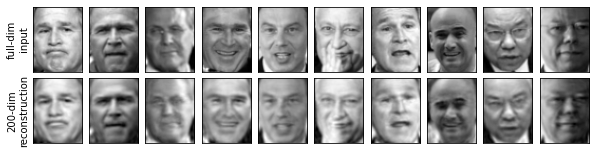

In [570]:
# Plot original faces and reconstructed faces
# Code slightly modified from the Python Data Science Handbook
fig, ax = plt.subplots(2, 10, figsize=(10, 2.5),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
start = 0
for i in range(start, start+10):
    ax[0, i-start].imshow(X[i].reshape(62, 47), cmap='binary_r')
    # Substitute reconstructed face i (as a vector) for np.zeros(62*47)
    ax[1, i-start].imshow(x_reconstructed[i].reshape(62, 47), cmap='binary_r')

ax[0, 0].set_ylabel('full-dim\ninput')
ax[1, 0].set_ylabel('200-dim\nreconstruction')

## 3. PCA using Power Iteration algorithmn


In [492]:
def powerIter(C,V):
    
    max_iter=1000
    iter_num =0
    results_dict = {}
    lamda_hist = []
    
    while iter_num < max_iter :
        z = C.dot(V)
        V=z/np.linalg.norm(z)
        eigval_lamda = (V.T).dot(C).dot(V) # (1 * d).(d * d).(d * 1) = 1 * 1
        eigval_lamda = eigval_lamda.item() # gets the value from 2d array
        results_dict[eigval_lamda] = V 
        lamda_hist.append(eigval_lamda)
        iter_num += 1
    
    
    return iter_num, lamda_hist,results_dict 
    

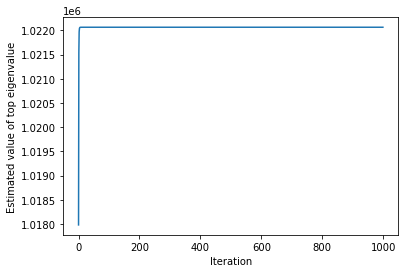

Estimated top eigenvalue: 1022065.3523433283
PC# 1
[0.00275768 0.003669   0.00503992 ... 0.00826745 0.00717774 0.00644891]


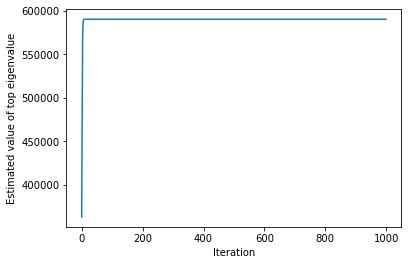

Estimated top eigenvalue: 590401.0255264451
PC# 2
[ 0.01458718  0.01397873  0.01419204 ... -0.03599009 -0.03504829
 -0.03373259]


In [571]:
n,d=X.shape
res=[]
C = compute_cov_full(X_demean) # d * d
for i in range(200):
    V = np.random.rand(d,1)
    iter_num, lamda_hist,results_dict  = powerIter(C,V)
    lamda_hist.sort() # sort the list in ascending order
    lamda = lamda_hist[-1] #highest lamda or highest eigen value
    eigvec = results_dict[lamda]
    res.append(eigvec.flatten())
    if i <=1:
        plt.plot(lamda_hist)
        plt.xlabel('Iteration')
        plt.ylabel('Estimated value of top eigenvalue')
        plt.show()

        print("Estimated top eigenvalue:", lamda)
        print("PC# "+str(i+1))
        print(eigvec.flatten())
    C = C -  lamda *(eigvec.dot(eigvec.T))

In [580]:
V = np.array(res) #p*d
power_scores = (V.dot(X_demean.T)).T 
power_scores_df = pd.DataFrame(data = power_scores[:,:2], columns =['pca1',
                                                   'pca2'])
print(pca_scores_df.head())

          pca1         pca2
0  -780.995422  -237.931213
1  1236.010986   734.585388
2   170.568359 -1359.862793
3  1360.042969   287.000305
4  -985.719604  1236.501343


In [581]:
x_reconstructed = V.T.dot(power_scores.T).T + np.mean(X,axis=0)

Text(0, 0.5, '200-dim\nreconstruction')

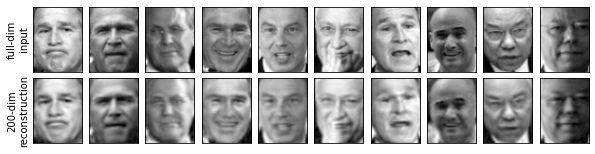

In [582]:
# Plot original faces and reconstructed faces
# Code slightly modified from the Python Data Science Handbook
fig, ax = plt.subplots(2, 10, figsize=(10, 2.5),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
start = 0
for i in range(start, start+10):
    ax[0, i-start].imshow(X[i].reshape(62, 47), cmap='binary_r')
    # Substitute reconstructed face i (as a vector) for np.zeros(62*47)
    ax[1, i-start].imshow(x_reconstructed[i].reshape(62, 47), cmap='binary_r')

ax[0, 0].set_ylabel('full-dim\ninput')
ax[1, 0].set_ylabel('200-dim\nreconstruction')